# Product Category Clustering
## Grouping 65 Amazon Products into 4-6 Meta-Categories
---
**Objective:** Simplify the dataset by clustering products into broader categories.

**Approach:**
1. Extract and clean category information from the `categories` column
2. Use TF-IDF on product names + categories to create feature vectors
3. Apply K-Means clustering and determine optimal number of clusters
4. Validate and label clusters
5. Save cluster assignments for summarization notebook

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import normalize
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
print('Libraries loaded')

Libraries loaded


## 2. Load Data

In [ ]:
df = pd.read_csv('../data/data_cleaned.csv')
print(f'Dataset: {len(df):,} reviews, {df["name"].nunique()} unique products')

Dataset: 28,332 reviews, 65 unique products


## 3. Build Product-Level DataFrame

Clustering is at the product level (65 products), not the review level (28K reviews).

In [3]:
# Create one row per product with aggregated info
products = df.groupby('name').agg(
    review_count=('reviews.text', 'count'),
    avg_rating=('reviews.rating', 'mean'),
    categories=('categories', 'first'),
    primary_category=('primaryCategories', 'first'),
    brand=('brand', 'first'),
    manufacturer=('manufacturer', 'first')
).reset_index()

print(f'Products: {len(products)}')
products.head(10)

Products: 65


,name,review_count,avg_rating,categories,primary_category,brand,manufacturer
0,"All-New Fire 7 Tablet with Alexa, 7"" Display, ...",82,4.585366,"Fire Tablets,Computers/Tablets & Networking,An...",Electronics,Amazon,Amazon
1,"All-New Fire HD 8 Kids Edition Tablet, 8 HD Di...",233,4.630901,"Fire Tablets,Computers/Tablets & Networking,Wa...",Electronics,Amazon,Amazon
2,"All-New Fire HD 8 Kids Edition Tablet, 8 HD Di...",293,4.641638,"Fire Tablets,Tablets,Amazon Tablets,Computers ...",Electronics,Amazon,Amazon
3,"All-New Fire HD 8 Tablet with Alexa, 8 HD Disp...",883,4.578709,"Fire Tablets,Tablets,All Tablets,Amazon Tablet...",Electronics,Amazon,Amazon
4,"All-New Fire HD 8 Tablet with Alexa, 8 HD Disp...",160,4.600000,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,Amazon,Amazon
5,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",2370,4.584388,"Fire Tablets,Computers/Tablets & Networking,El...",Electronics,Amazon,Amazon
6,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",67,4.522388,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,Amazon,Amazon
7,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",140,4.542857,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,Amazon,Amazon
8,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",156,4.583333,"Fire Tablets,Tablets,All Tablets,Amazon Tablet...",Electronics,Amazon,Amazon
9,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",115,4.565217,"Fire Tablets,Computers,Tablets,All Tablets,Ama...",Electronics,Amazon,Amazon


In [4]:
# Look at all product names to understand what we're clustering
print('All products:')
for i, row in products.sort_values('review_count', ascending=False).iterrows():
    print(f'  [{row["review_count"]:>5}] {row["name"][:90]}')

All products:
  [ 8343] AmazonBasics AAA Performance Alkaline Batteries (36 Count)
  [ 3728] AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary
  [ 2443] Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers
  [ 2370] All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black
  [ 1676] Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case
  [ 1425] Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case
  [ 1212] Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case
  [ 1024] Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black
  [  987] Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers
  [  883] All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offer
  [  745] Fire Tablet with Alexa, 7 Display, 16 GB, Magenta - with Special Offers
  [  601] Amazon Tap Smart Assistant Alexaenabled (bla

## 4. Parse and Clean Categories

In [5]:
# The categories column is comma-separated with many labels per product
# Let's parse it and see what individual category labels exist

all_categories = []
for cats in products['categories']:
    individual = [c.strip() for c in str(cats).split(',')]
    all_categories.extend(individual)

cat_counts = Counter(all_categories)
print(f'Unique category labels: {len(cat_counts)}')
print(f'\nTop 30 most common:')
for cat, count in cat_counts.most_common(30):
    print(f'  {count:>3}x  {cat}')

Unique category labels: 314

Top 30 most common:
   44x  Electronics
   29x  Computers & Tablets
   25x  Tablets
   20x  Fire Tablets
   20x  Amazon Tablets
   19x  All Tablets
   19x  Electronics Features
   14x  Computers/Tablets & Networking
   14x  Amazon
   13x  Consumer Electronics
   12x  Smart Speakers
   10x  Amazon Ereaders
   10x  Kindle E-readers
   10x  Amazon Book Reader
   10x  Computers & Accessories
    9x  E-Readers & Accessories
    9x  Amazon Echo
    9x  Digital Device 3
    9x  Amazon Home
    8x  iPad & Tablets
    8x  Tablets & eBook Readers
    8x  Amazon Devices
    8x  Accessories
    7x  E-Readers
    7x  Featured Brands
    6x  Tablets & E-Readers
    6x  Hubs & Accessories
    6x  Surveillance & Smart Home Electronics
    6x  Digital Device Accessory
    6x  Amazon Device Accessories


In [6]:
# Create a combined text feature for each product:
# product name + all category labels (cleaned)

def clean_categories(cat_string):
    """Clean and deduplicate category labels."""
    cats = [c.strip().lower() for c in str(cat_string).split(',')]
    # Remove generic/noisy labels
    noise = ['robot check', 'frys', 'top rated', 'featured brands', 
             'walmart for business', 'amazon', 'see more', 'college',
             'back to college', 'electronics deals', 'digital device 3']
    cats = [c for c in cats if not any(n in c for n in noise)]
    return ' '.join(set(cats))  # deduplicate

products['clean_categories'] = products['categories'].apply(clean_categories)
products['cluster_text'] = products['name'].str.lower() + ' ' + products['clean_categories']

# Show a few examples
for i, row in products.head(3).iterrows():
    print(f'Product: {row["name"][:60]}')
    print(f'Cluster text: {row["cluster_text"][:150]}...')
    print()

Product: All-New Fire 7 Tablet with Alexa, 7" Display, 8 GB - Marine 
Cluster text: all-new fire 7 tablet with alexa, 7" display, 8 gb - marine blue electronics tablets & e-readers computers/tablets & networking android tablets tablet...

Product: All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, 
Cluster text: all-new fire hd 8 kids edition tablet, 8 hd display, 32 gb, blue kid-proof case electronics tablets & e-readers computers/tablets & networking tablets...

Product: All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, 
Cluster text: all-new fire hd 8 kids edition tablet, 8 hd display, 32 gb, pink kid-proof case kids' tablets tablets fire tablets computers & tablets...



## 5. TF-IDF Vectorization

In [7]:
# TF-IDF on the combined product name + categories text
tfidf = TfidfVectorizer(
    max_features=200,
    stop_words='english',
    ngram_range=(1, 2),  # unigrams and bigrams
    min_df=1
)

tfidf_matrix = tfidf.fit_transform(products['cluster_text'])

print(f'TF-IDF matrix shape: {tfidf_matrix.shape}')
print(f'Top features: {tfidf.get_feature_names_out()[:20]}')

TF-IDF matrix shape: (65, 200)
Top features: ['16' '16 gb' '2nd' '2nd generation' '300' '300 ppi' '32' '32 gb'
 'accessories' 'accessories cases' 'accessories computers'
 'accessories peripherals' 'accessories surveillance' 'accessory'
 'adapter' 'adapters' 'adapters cables' 'alexa' 'alexa hd' 'amazon']


## 6. Find Optimal Number of Clusters

K=2: Inertia=45.52, Silhouette=0.1543
K=3: Inertia=40.21, Silhouette=0.1649
K=4: Inertia=36.07, Silhouette=0.1963
K=5: Inertia=33.05, Silhouette=0.2190
K=6: Inertia=30.31, Silhouette=0.2364
K=7: Inertia=28.16, Silhouette=0.2526
K=8: Inertia=25.80, Silhouette=0.2531
K=9: Inertia=23.98, Silhouette=0.2770
K=10: Inertia=22.86, Silhouette=0.2479


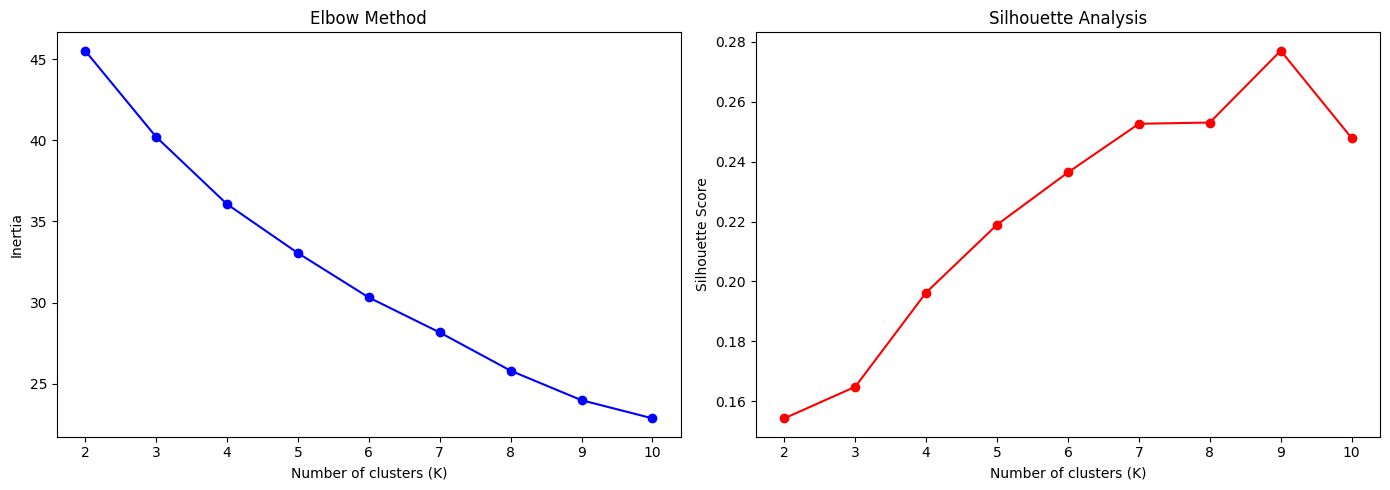


Best K by silhouette: 9


In [8]:
# Test K=2 to K=10
K_range = range(2, 11)
inertias = []
silhouettes = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(tfidf_matrix)
    inertias.append(km.inertia_)
    sil = silhouette_score(tfidf_matrix, labels)
    silhouettes.append(sil)
    print(f'K={k}: Inertia={km.inertia_:.2f}, Silhouette={sil:.4f}')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].set_xticks(list(K_range))

# Silhouette plot
axes[1].plot(K_range, silhouettes, 'ro-')
axes[1].set_xlabel('Number of clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].set_xticks(list(K_range))

plt.tight_layout()
plt.show()

best_k = K_range[np.argmax(silhouettes)]
print(f'\nBest K by silhouette: {best_k}')

## 7. Apply K-Means with Chosen K

The project requires 4-6 meta-categories. Choose the K that makes most sense from the analysis above. If the optimal K falls outside 4-6, pick the best within that range.

In [19]:
# Choose K - adjust based on elbow/silhouette results
# Default to 5 based on our domain knowledge (batteries, tablets, kids tablets, e-readers, speakers)
CHOSEN_K = 6  # ADJUSTED based on plots above

kmeans = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=20)
products['cluster'] = kmeans.fit_predict(tfidf_matrix)

sil_score = silhouette_score(tfidf_matrix, products['cluster'])
print(f'K={CHOSEN_K}, Silhouette Score: {sil_score:.4f}')

print(f'\nCluster sizes:')
print(products['cluster'].value_counts().sort_index())

K=6, Silhouette Score: 0.2364

Cluster sizes:
cluster
0    20
1    10
2     9
3     7
4    11
5     8
Name: count, dtype: int64


## 8. Inspect Clusters

In [20]:
# Show products in each cluster
for cluster_id in sorted(products['cluster'].unique()):
    cluster_products = products[products['cluster'] == cluster_id]
    total_reviews = cluster_products['review_count'].sum()
    avg_rating = df[df['name'].isin(cluster_products['name'])]['reviews.rating'].mean()
    
    print(f'\n{"=" * 70}')
    print(f'CLUSTER {cluster_id} | {len(cluster_products)} products | '
          f'{total_reviews:,} reviews | avg rating: {avg_rating:.2f}')
    print(f'{"=" * 70}')
    
    for _, p in cluster_products.sort_values('review_count', ascending=False).iterrows():
        print(f'  [{p["review_count"]:>5}] {p["name"][:80]}')
    
    # Top category labels in this cluster
    cluster_cats = []
    for cats in cluster_products['categories']:
        cluster_cats.extend([c.strip() for c in str(cats).split(',')])
    top_cats = Counter(cluster_cats).most_common(5)
    print(f'  Top categories: {", ".join([c[0] for c in top_cats])}')


CLUSTER 0 | 20 products | 14,396 reviews | avg rating: 4.56
  [ 2443] Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offer
  [ 2370] All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, 
  [ 1676] Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case
  [ 1425] Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case
  [ 1212] Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case
  [ 1024] Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black
  [  987] Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers
  [  883] All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Spe
  [  745] Fire Tablet with Alexa, 7 Display, 16 GB, Magenta - with Special Offers
  [  293] All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case
  [  233] All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case
 

In [22]:
# Top TF-IDF terms per cluster (what makes each cluster unique)
print('Top TF-IDF terms per cluster:')
print('-' * 50)

feature_names = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for cluster_id in range(CHOSEN_K):
    top_terms = [feature_names[i] for i in order_centroids[cluster_id, :10]]
    print(f'Cluster {cluster_id}: {", ".join(top_terms)}')

Top TF-IDF terms per cluster:
--------------------------------------------------
Cluster 0: tablets, tablets tablets, hd, computers tablets, tablets computers, computers, tablet, gb, display, hd display
Cluster 1: readers, kindle, tablets, kindle readers, fi includes, reader, readers accessories, resolution display, display 300, 300
Cluster 2: smart, home, speakers, smart home, electronics, audio, echo, hubs, assistants, consumer
Cluster 3: supplies, pet, batteries, crates, dog, household, health, cat, crate, pet supplies
Cluster 4: accessories, cables, power, laptop, adapters, usb, computers accessories, computer, kindle, computers
Cluster 5: tv, video, kitchen, media, audio, home, streaming, streaming media, audio video, dining


## 9. Assign Meaningful Cluster Names

Based on inspecting the clusters above, assign human-readable names.

In [23]:
# UPDATE these labels based on the cluster inspection above
# The mapping below is a starting point - adjust after seeing cluster contents
cluster_names = {
    0: 'Fire Tablets',
    1: 'E-Readers',
    2: 'Smart Speakers',
    3: 'Batteries & Household',
    4: 'Accessories',
    5: 'Media & Home',
}


products['cluster_name'] = products['cluster'].map(cluster_names)

print('Cluster assignments:')
for name in cluster_names.values():
    subset = products[products['cluster_name'] == name]
    print(f'\n{name}: {len(subset)} products, {subset["review_count"].sum():,} reviews')

Cluster assignments:

Fire Tablets: 20 products, 14,396 reviews

E-Readers: 10 products, 1,049 reviews

Smart Speakers: 9 products, 632 reviews

Batteries & Household: 7 products, 12,086 reviews

Accessories: 11 products, 138 reviews

Media & Home: 8 products, 31 reviews


## 10. Visualize Clusters (PCA)

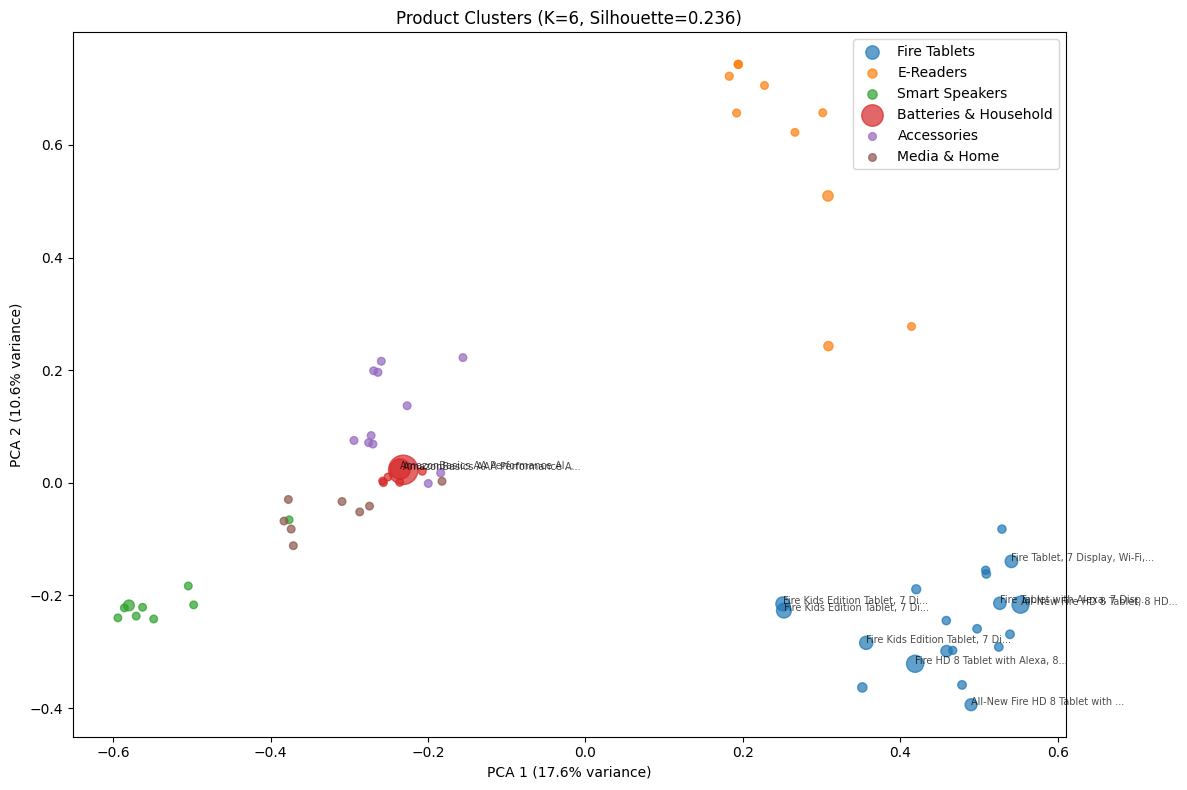

In [24]:
# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(tfidf_matrix.toarray())

products['pca_x'] = coords[:, 0]
products['pca_y'] = coords[:, 1]

fig, ax = plt.subplots(figsize=(12, 8))

for cluster_id in sorted(products['cluster'].unique()):
    cluster_data = products[products['cluster'] == cluster_id]
    label = cluster_names.get(cluster_id, f'Cluster {cluster_id}')
    ax.scatter(cluster_data['pca_x'], cluster_data['pca_y'], 
              s=cluster_data['review_count'] / 20 + 30,  # size by review count
              label=label, alpha=0.7)

# Label some key products
for _, row in products.nlargest(10, 'review_count').iterrows():
    short_name = row['name'][:30] + '...'
    ax.annotate(short_name, (row['pca_x'], row['pca_y']),
               fontsize=7, alpha=0.7)

ax.set_xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title(f'Product Clusters (K={CHOSEN_K}, Silhouette={sil_score:.3f})')
ax.legend()
plt.tight_layout()
plt.show()

## 11. Cluster Statistics

In [25]:
# Detailed stats per cluster
cluster_stats = []

for cluster_id in sorted(products['cluster'].unique()):
    cluster_products = products[products['cluster'] == cluster_id]
    cluster_reviews = df[df['name'].isin(cluster_products['name'])]
    
    sentiment_dist = cluster_reviews['sentiment'].value_counts(normalize=True)
    
    cluster_stats.append({
        'Cluster': cluster_names.get(cluster_id, f'Cluster {cluster_id}'),
        'Products': len(cluster_products),
        'Reviews': len(cluster_reviews),
        'Avg Rating': cluster_reviews['reviews.rating'].mean().round(2),
        '% Positive': (sentiment_dist.get('Positive', 0) * 100).round(1),
        '% Neutral': (sentiment_dist.get('Neutral', 0) * 100).round(1),
        '% Negative': (sentiment_dist.get('Negative', 0) * 100).round(1),
    })

stats_df = pd.DataFrame(cluster_stats)
print('Cluster Summary:')
stats_df

Cluster Summary:


,Cluster,Products,Reviews,Avg Rating,% Positive,% Neutral,% Negative
0,Fire Tablets,20,14396,4.56,93.2,4.1,2.6
1,E-Readers,10,1049,4.66,95.2,3.2,1.5
2,Smart Speakers,9,632,4.54,91.9,4.4,3.6
3,Batteries & Household,7,12086,4.45,86.1,4.4,9.5
4,Accessories,11,138,4.31,82.6,9.4,8.0
5,Media & Home,8,31,4.39,83.9,3.2,12.9


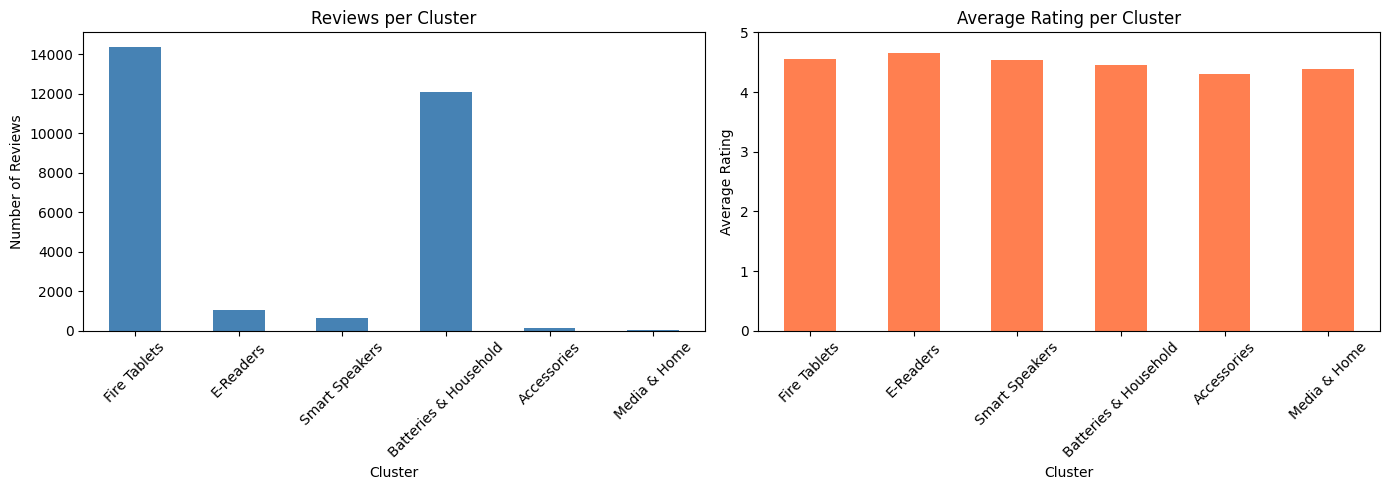

In [26]:
# Sentiment distribution by cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reviews per cluster
stats_df.set_index('Cluster')['Reviews'].plot(
    kind='bar', ax=axes[0], color='steelblue'
)
axes[0].set_title('Reviews per Cluster')
axes[0].set_ylabel('Number of Reviews')
axes[0].tick_params(axis='x', rotation=45)

# Average rating per cluster
stats_df.set_index('Cluster')['Avg Rating'].plot(
    kind='bar', ax=axes[1], color='coral'
)
axes[1].set_title('Average Rating per Cluster')
axes[1].set_ylabel('Average Rating')
axes[1].set_ylim(0, 5)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 12. Silhouette Analysis per Cluster

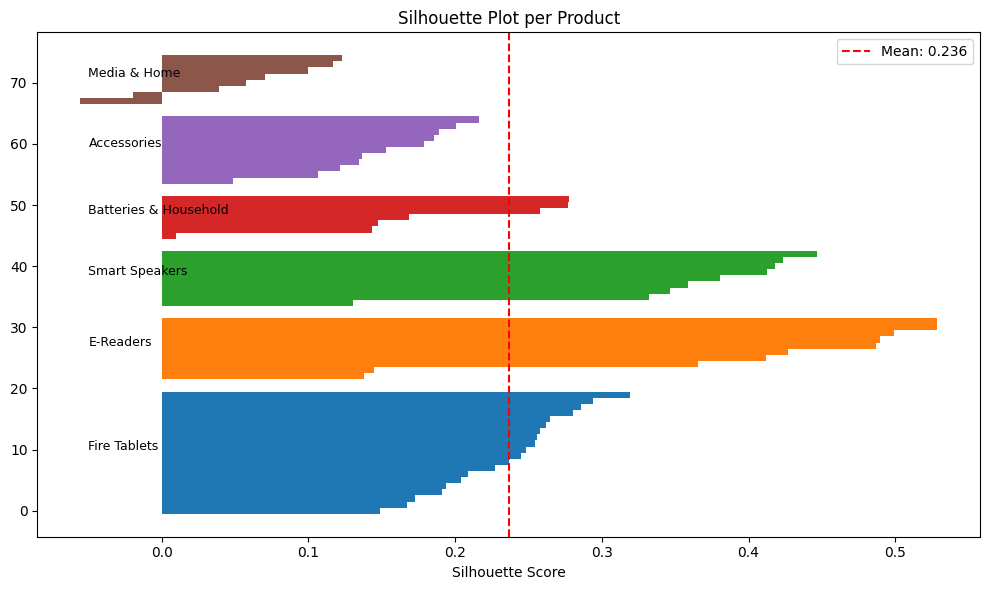

In [27]:
# Per-sample silhouette scores
sample_silhouettes = silhouette_samples(tfidf_matrix, products['cluster'])

fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 0

for cluster_id in sorted(products['cluster'].unique()):
    cluster_sils = sample_silhouettes[products['cluster'] == cluster_id]
    cluster_sils.sort()
    
    y_upper = y_lower + len(cluster_sils)
    ax.barh(range(y_lower, y_upper), cluster_sils, height=1.0)
    ax.text(-0.05, y_lower + 0.5 * len(cluster_sils),
            cluster_names.get(cluster_id, f'C{cluster_id}'), fontsize=9)
    y_lower = y_upper + 2

ax.axvline(x=sil_score, color='red', linestyle='--', label=f'Mean: {sil_score:.3f}')
ax.set_xlabel('Silhouette Score')
ax.set_title('Silhouette Plot per Product')
ax.legend()
plt.tight_layout()
plt.show()

## 13. Map Clusters Back to Reviews and Save

In [28]:
# Create product -> cluster mapping
product_cluster_map = products.set_index('name')[['cluster', 'cluster_name']].to_dict('index')

# Map to full review dataset
df['cluster'] = df['name'].map({k: v['cluster'] for k, v in product_cluster_map.items()})
df['cluster_name'] = df['name'].map({k: v['cluster_name'] for k, v in product_cluster_map.items()})

print(f'Cluster distribution across all reviews:')
print(df['cluster_name'].value_counts())

# Verify no unmapped products
unmapped = df['cluster'].isnull().sum()
print(f'\nUnmapped reviews: {unmapped}')

Cluster distribution across all reviews:
cluster_name
Fire Tablets             14396
Batteries & Household    12086
E-Readers                 1049
Smart Speakers             632
Accessories                138
Media & Home                31
Name: count, dtype: int64

Unmapped reviews: 0


In [ ]:
# Save
df.to_csv('../data/data_with_clusters.csv', index=False)
print(f'Saved: data_with_clusters.csv ({len(df):,} rows)')

# Also save the product-level clustering info
products_out = products[['name', 'review_count', 'avg_rating', 'cluster', 
                         'cluster_name', 'primary_category']]
products_out.to_csv('product_clusters.csv', index=False)
print(f'Saved: product_clusters.csv ({len(products_out)} products)')

Saved: data_with_clusters.csv (28,332 rows)
Saved: product_clusters.csv (65 products)


## 14. Summary

### Method
TF-IDF vectorization (product names + cleaned category labels, unigrams & bigrams) → K-Means clustering

### Cluster Selection
- Tested K=2 to K=10 using elbow method and silhouette analysis
- Best silhouette was K=9 (0.2770), but project requires 4-6 categories
- Within the 4-6 range, K=6 had the best silhouette score (0.2364)
- Silhouette scores are modest overall, reflecting overlapping category labels across products (e.g., Fire Tablets and Kids Tablets share many terms)

### Cluster Results (K=6, Silhouette=0.2364)

| Cluster | Products | Reviews | Avg Rating | % Positive | % Negative | Key Products |
|---------|----------|---------|------------|------------|------------|-------------|
| **Fire Tablets** | 20 | 14,396 | 4.56 | 93.2% | 2.6% | Fire HD 8, Fire 7, Kids Edition (various colors/sizes) |
| **Batteries & Household** | 7 | 12,086 | 4.45 | 86.1% | 9.5% | AmazonBasics AA/AAA, dog crates, cat litter, file organizer |
| **E-Readers** | 10 | 1,049 | 4.66 | 95.2% | 1.5% | Kindle Voyage, Kindle E-reader, Kindle Oasis (various) |
| **Smart Speakers** | 9 | 632 | 4.54 | 91.9% | 3.6% | Amazon Tap, Echo (1st/2nd gen), Echo Dot, Echo Show |
| **Accessories** | 11 | 138 | 4.31 | 82.6% | 8.0% | Chargers, laptop bags, keyboard, USB cables, laptop stand |
| **Media & Home** | 8 | 31 | 4.39 | 83.9% | 12.9% | Fire TV Stick, hard drive case, speaker wire, Nespresso pods, silicone handle |

### Key Observations
- **Fire Tablets** and **Batteries & Household** dominate with 93% of all reviews combined
- **E-Readers** have the highest average rating (4.66) and lowest negative rate (1.5%)
- **Media & Home** has the highest negative rate (12.9%) but only 31 reviews — small sample
- **Batteries & Household** includes some non-battery products (pet crates, file organizers) grouped due to shared Amazon/Household category labels — these have very few reviews (1-9 each) so minimal impact
- **Accessories** and **Media & Home** are small clusters that could be merged if needed, but keeping 6 categories provides good granularity for the summarization task

### Files Produced
- `data_with_clusters.csv` — full review dataset (28,332 rows) with cluster assignments
- `product_clusters.csv` — product-level clustering summary (65 products)

### Next Steps
Use clusters in the summarization notebook to generate per-category recommendation articles including top 3 products, key complaints, and worst product per category.